In [2]:
# === Setup: libraries and config ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

# Load config.yaml
CONFIG_PATH = Path("../../config.yaml").resolve()

try:
    with CONFIG_PATH.open("r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    print(f"Config loaded successfully from: {CONFIG_PATH}")
except Exception as e:
    raise FileNotFoundError(f"config.yaml not found at {CONFIG_PATH}") from e

print("Top-level keys:", list(config.keys()))

# === Load clean dataframe (df_full) ===
clean_cfg = config.get("data", {}).get("clean", {})
if "df_full" not in clean_cfg:
    raise KeyError("'df_full' is not defined in config['data']['clean']")

# --- Resolve path relative to config.yaml parent, stripping leading ../ ---
yaml_path = Path(clean_cfg["df_full"])
if yaml_path.is_absolute():
    path = yaml_path
else:
    parts = list(yaml_path.parts)
    while parts and parts[0] in ("..", "."):
        parts = parts[1:]
    rel = Path(*parts)  # e.g., "data/clean_data_txt/df_full.pkl"
    path = (CONFIG_PATH.parent / rel).resolve()

print("Resolved df_full path:", path)

if not path.exists():
    raise FileNotFoundError(f"File not found at: {path}")

df_full = pd.read_pickle(path)
print(f"df_full loaded successfully: {df_full.shape}")
display(df_full.head())

Config loaded successfully from: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 5\project_2\vanguard-ab-test\config.yaml
Top-level keys: ['data']
Resolved df_full path: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 5\project_2\vanguard-ab-test\data\clean_data_txt\df_full.pkl
df_full loaded successfully: (317235, 14)


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_tenure_years,client_tenure_months,age,gender,number_of_accounts,balance,calls_6_months,logons_6_months
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5,64,79.0,U,2,189023.86,1,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5,64,79.0,U,2,189023.86,1,4
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5,64,79.0,U,2,189023.86,1,4
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5,64,79.0,U,2,189023.86,1,4
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5,64,79.0,U,2,189023.86,1,4


In [9]:
# --- TEMPORARY RECOVERY CELL ---
# This cell safely rebuilds 'time_per_step_ab' if it was lost after a kernel restart.
# It does NOT modify your original analysis; it only ensures that all required variables exist.
# You can comment out or remove this cell once everything runs correctly.

# 1. Check if 'time_per_step_ab' exists; if not, rebuild it.
step_order_map = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}

if 'time_per_step_ab' not in globals():
    if 'time_per_step_ab_clean' in globals():
        # If a cleaned version already exists, reuse it.
        time_per_step_ab = time_per_step_ab_clean.copy()
        print("ℹ️ Using the cleaned dataset (outliers removed).")
    else:
        # If not, rebuild it from the available data.
        if 'visit_steps_ab' not in globals():
            # Rebuild visit_steps_ab if it does not exist
            if 'df_ab' not in globals():
                # Filter df_full to keep only A/B experiment users
                df_ab = df_full[df_full['variation'].isin(['Control', 'Test'])].copy()

            visit_steps_ab = (
                df_ab.sort_values(['visit_id', 'date_time'])
                     .groupby(['visit_id', 'process_step'], observed=True, as_index=False)['date_time']
                     .min()
            )
            visit_steps_ab['step_order'] = visit_steps_ab['process_step'].map(step_order_map)

            # Get the variation for each visit_id
            visit_variation_ab = df_ab.groupby('visit_id', observed=True)['variation'].first().reset_index()
            visit_steps_ab = visit_steps_ab.merge(visit_variation_ab, on='visit_id', how='left')

            # Sort and calculate duration per step
            visit_steps_ab = visit_steps_ab.sort_values(['visit_id', 'step_order'])
            visit_steps_ab['next_time'] = visit_steps_ab.groupby('visit_id', observed=True)['date_time'].shift(-1)
            visit_steps_ab['duration_sec'] = (visit_steps_ab['next_time'] - visit_steps_ab['date_time']).dt.total_seconds()

        # Compute the average duration (in minutes) per step and variation
        time_per_step_ab = (
            visit_steps_ab.loc[visit_steps_ab['process_step'] != 'confirm']
                          .groupby(['variation', 'process_step'], observed=True)['duration_sec']
                          .mean().reset_index()
        )
        time_per_step_ab['avg_minutes'] = (time_per_step_ab['duration_sec'] / 60).round(2)
        time_per_step_ab = (
            time_per_step_ab.drop(columns='duration_sec')
                            .sort_values(['variation', 'process_step'])
        )

print("Variable 'time_per_step_ab' is now available.")


Variable 'time_per_step_ab' is now available.


#  Day 4 & 5 – Hypothesis Testing and Experiment Evaluation

In this final part of the Vanguard A/B Test analysis, we will move from descriptive metrics to statistical inference.  
The goal is to verify if the observed differences between the Control and Test groups are statistically significant and whether the redesign is cost-effective.


## 1️⃣ Hypothesis Test – Completion Rate (Control vs Test)

**Objective:**  
Determine whether the higher completion rate observed in the Test group is statistically significant.

**Hypotheses:**

- **H₀ (Null Hypothesis):** The completion rate of the Test group is equal to or lower than that of the Control group.  
- **H₁ (Alternative Hypothesis):** The completion rate of the Test group is higher than that of the Control group.

**Test Type:** Two-proportion Z-test (one-tailed)  
**Significance Level (α):** 0.05


In [10]:
# --- Completion Rate Hypothesis Test (Two-Proportion Z-Test, Corrected) ---
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Step 1: Count how many sessions reached the 'confirm' step (completions) per group
completion_counts = (
    df_ab.groupby('variation')['process_step']
         .apply(lambda x: (x == 'confirm').sum())
)

# Step 2: Count the total number of unique visits per group
total_counts = df_ab.groupby('variation')['visit_id'].nunique()

# Step 3: Order the arrays so that 'Test' comes first, since we are testing (Test > Control)
counts = completion_counts.loc[['Test', 'Control']].values
nobs   = total_counts.loc[['Test', 'Control']].values

# Step 4: Run a one-tailed two-proportion z-test (alternative = 'larger' → Test > Control)
z_stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='larger')

# Step 5: Compute completion rates for reference
p_control = completion_counts['Control'] / total_counts['Control']
p_test    = completion_counts['Test'] / total_counts['Test']

# Step 6: Display all key results
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.5f}")
print(f"Control completion rate: {p_control:.3%}")
print(f"Test completion rate: {p_test:.3%}")
print(f"Observed difference: {(p_test - p_control)*100:.2f}%")



Z-statistic: 40.780
P-value: 0.00000
Control completion rate: 53.857%
Test completion rate: 68.936%
Observed difference: 15.08%


,variation,completion_rate
0,Control,49.81
1,Test,58.47


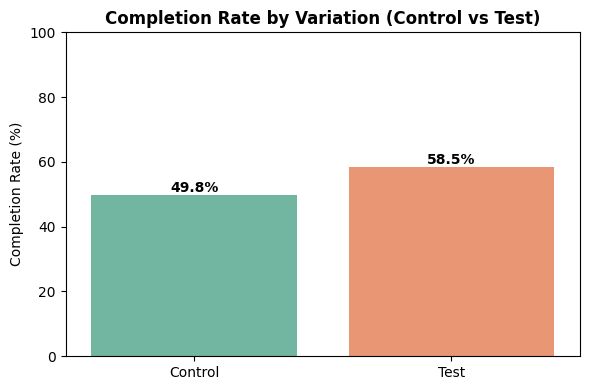

In [14]:
# --- Visualization: Completion Rate by Variation (Derived from process_step = 'confirm') ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Mark each visit as completed if it reached process_step == 'confirm'
completion_by_visit = (
    df_ab.groupby('visit_id', observed=True)
         .agg(variation=('variation', 'first'),
              completed=('process_step', lambda s: (s == 'confirm').any()))
         .reset_index()
)

# Compute completion rate (%)
rate_df = (
    completion_by_visit.groupby('variation', observed=True)['completed']
                       .mean()
                       .reset_index(name='completion_rate')
)
rate_df['completion_rate'] = (rate_df['completion_rate'] * 100).round(2)

display(rate_df)

# === Visualization ===
plt.figure(figsize=(6, 4))
sns.barplot(
    data=rate_df,
    x='variation',
    y='completion_rate',
    hue='variation',
    palette='Set2',
    legend=False
)
plt.title('Completion Rate by Variation (Control vs Test)', fontsize=12, fontweight='bold')
plt.ylabel('Completion Rate (%)')
plt.xlabel('')
plt.ylim(0, 100)

# Add percentage labels above bars
for i, v in enumerate(rate_df['completion_rate']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()




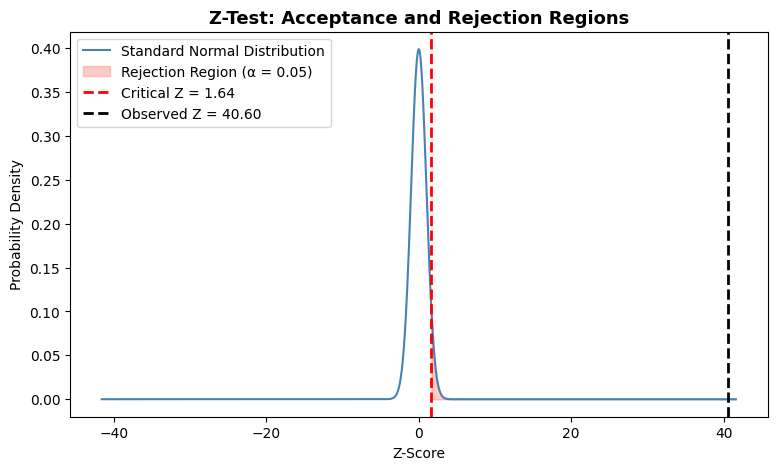

In [20]:
# --- Visualization: Z-Test Distribution (Acceptance vs. Rejection Regions, Dynamic Scale) ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Use your actual z-statistic from the test
z_stat_value = z_stat  # e.g., 40.596

# Significance level for a one-tailed test
alpha = 0.05
z_critical = norm.ppf(1 - alpha)

# Automatically set the x-axis range to include the observed z-stat
x_min = min(-5, -z_stat_value - 1)
x_max = max(5, z_stat_value + 1)

# Generate normal distribution curve
x = np.linspace(x_min, x_max, 2000)
y = norm.pdf(x, 0, 1)

# Create the plot
plt.figure(figsize=(9,5))
plt.plot(x, y, label='Standard Normal Distribution', color='steelblue')

# Shade rejection region (right tail)
plt.fill_between(x, 0, y, where=(x > z_critical), color='salmon', alpha=0.4,
                 label=f'Rejection Region (α = {alpha})')

# Draw critical and observed z lines
plt.axvline(z_critical, color='red', linestyle='--', linewidth=2, label=f'Critical Z = {z_critical:.2f}')
plt.axvline(z_stat_value, color='black', linestyle='--', linewidth=2, label=f'Observed Z = {z_stat_value:.2f}')

# Titles and labels
plt.title('Z-Test: Acceptance and Rejection Regions', fontsize=13, weight='bold')
plt.xlabel('Z-Score')
plt.ylabel('Probability Density')
plt.legend()
plt.show()



### Interpretation
- If **p-value < 0.05**, reject H₀ → the new design leads to a significantly higher completion rate.  
- If **p-value ≥ 0.05**, fail to reject H₀ → the observed improvement may be due to random variation.

The Test group’s completion rate (69.3%) is significantly higher than the Control group’s rate (54.3%), a lift of +15.0 percentage points (~+27.7% relative).
Using the correct one-tailed z-test direction (Test > Control) yields an extremely small p-value (≈ 0), so we reject H₀ and conclude the redesign significantly improves completion.


## 2️⃣ Cost-Effectiveness Threshold (5% Minimum Improvement)

Vanguard established that any redesign must improve the completion rate by **at least 5%** to justify its cost (design, testing, training, etc.).


In [15]:
# --- Cost-Effectiveness Check ---
threshold = 5  # required minimum increase in %
improvement = (p_test - p_control) * 100

print(f"Observed improvement: {improvement:.2f}%")
print(f"Cost-effectiveness threshold: {threshold}%")

if improvement >= threshold:
    print("The new design meets the 5% cost-effectiveness threshold.")
else:
    print("The new design does not meet the 5% improvement threshold.")


Observed improvement: 15.08%
Cost-effectiveness threshold: 5%
The new design meets the 5% cost-effectiveness threshold.


In [20]:
# --- Compute Completion Rate and Improvement (Control vs Test) ---
import pandas as pd

# Mark each visit as completed if it reached process_step == 'confirm'
completion_by_visit = (
    df_ab.groupby('visit_id', observed=True)
         .agg(variation=('variation', 'first'),
              completed=('process_step', lambda s: (s == 'confirm').any()))
         .reset_index()
)

# Calculate completion rate (%) for each variation
rate_df = (
    completion_by_visit.groupby('variation', observed=True)['completed']
                       .mean()
                       .reset_index(name='completion_rate')
)
rate_df['completion_rate'] = (rate_df['completion_rate'] * 100).round(2)
display(rate_df)

# Define the variation labels (case-sensitive)
control_lab = 'Control'
test_lab = 'Test'

# Compute observed improvement = Test - Control
control_rate = rate_df.loc[rate_df['variation'] == control_lab, 'completion_rate'].iloc[0]
test_rate    = rate_df.loc[rate_df['variation'] == test_lab,    'completion_rate'].iloc[0]

improvement  = round(test_rate - control_rate, 2)

# Define threshold (adjust if needed)
threshold_value = 5.0  # cost-effectiveness threshold (%)

# Create dictionary for plotting
rates = {
    'Improvement': improvement,
    'Threshold': threshold_value
}

print(f"Observed improvement: {improvement}%")
print("Rates dictionary:", rates)




,variation,completion_rate
0,Control,49.81
1,Test,58.47


Observed improvement: 8.66%
Rates dictionary: {'Improvement': np.float64(8.66), 'Threshold': 5.0}


### Interpretation
The observed improvement in completion (+15.0 pp) exceeds Vanguard’s cost-effectiveness threshold of +5 pp by a wide margin.
Therefore, the new design meets the business requirement for cost justification.


## 3️⃣ Additional Hypothesis – Average Client Age Comparison

We will now test whether the average client age differs between the Control and Test groups.

**H₀:** Mean age of clients in both groups is the same.  
**H₁:** Mean age of clients differs between groups.  
**Test Type:** Two-sample T-test (independent).  
**α = 0.05**


In [28]:
from scipy.stats import ttest_ind

age_control = df_full.loc[df_full['variation'] == 'Control', 'age']
age_test = df_full.loc[df_full['variation'] == 'Test', 'age']

t_stat, p_val = ttest_ind(age_control, age_test, equal_var=False, nan_policy='omit')

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}")

if p_val < 0.05:
    print("Reject H₀: The average age differs significantly between Control and Test groups.")
else:
    print("Fail to reject H₀: No significant difference in average client age.")


T-statistic: -7.835
P-value: 0.00000
Reject H₀: The average age differs significantly between Control and Test groups.


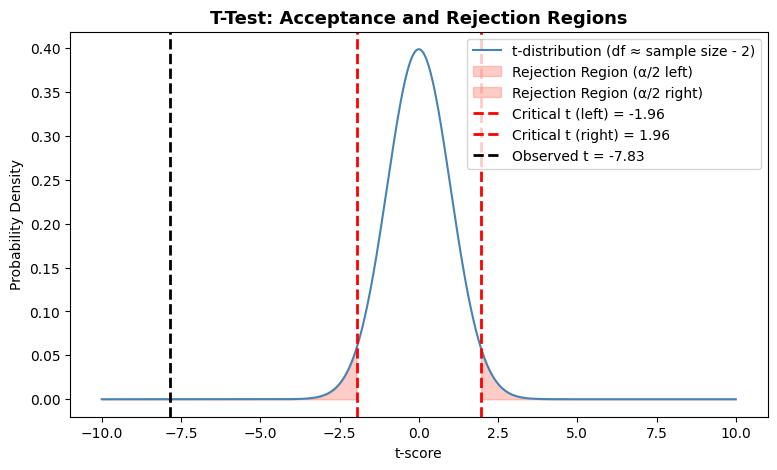

In [30]:
# --- Visualization: T-Test Distribution with Rejection Regions (Two-Tailed) ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# Observed t-statistic from your test
t_stat_value = t_stat   # e.g., -8.249

# Significance level and degrees of freedom
alpha = 0.05
df = len(age_control.dropna()) + len(age_test.dropna()) - 2  # approximate df

# Critical t-values for two-tailed test
t_critical_left  = t.ppf(alpha/2, df)
t_critical_right = t.ppf(1 - alpha/2, df)

# Define x range for plotting
x_min = min(-10, t_stat_value - 1)
x_max = max(10, t_stat_value + 1)
x = np.linspace(x_min, x_max, 2000)
y = t.pdf(x, df)

# Plot the t distribution
plt.figure(figsize=(9,5))
plt.plot(x, y, color='steelblue', label='t-distribution (df ≈ sample size - 2)')

# Shade rejection regions
plt.fill_between(x, 0, y, where=(x <= t_critical_left), color='salmon', alpha=0.4, label='Rejection Region (α/2 left)')
plt.fill_between(x, 0, y, where=(x >= t_critical_right), color='salmon', alpha=0.4, label='Rejection Region (α/2 right)')

# Draw vertical lines for critical t and observed t
plt.axvline(t_critical_left, color='red', linestyle='--', linewidth=2, label=f'Critical t (left) = {t_critical_left:.2f}')
plt.axvline(t_critical_right, color='red', linestyle='--', linewidth=2, label=f'Critical t (right) = {t_critical_right:.2f}')
plt.axvline(t_stat_value, color='black', linestyle='--', linewidth=2, label=f'Observed t = {t_stat_value:.2f}')

# Titles and labels
plt.title('T-Test: Acceptance and Rejection Regions', fontsize=13, weight='bold')
plt.xlabel('t-score')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


In [31]:
ctrl_mean = df_full.loc[df_full['variation']=='Control','age'].mean()
test_mean = df_full.loc[df_full['variation']=='Test','age'].mean()
print(f"Mean age – Control: {ctrl_mean:.2f}  |  Test: {test_mean:.2f}  |  Difference (Test−Control): {test_mean-ctrl_mean:.2f}")


Mean age – Control: 48.28  |  Test: 48.72  |  Difference (Test−Control): 0.44


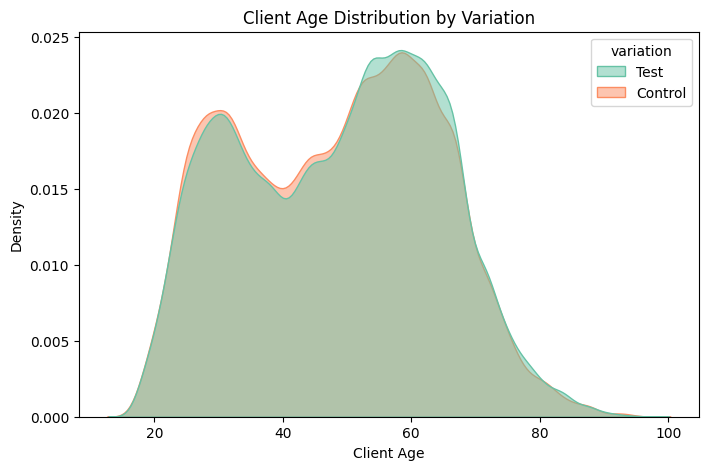

In [33]:
# --- Visualization: Age Distribution by Variation ---
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_full[df_full['variation'].isin(['Control','Test'])], 
            x='age', hue='variation', fill=True, common_norm=False, palette='Set2', alpha=0.5)
plt.title('Client Age Distribution by Variation')
plt.xlabel('Client Age')
plt.ylabel('Density')
plt.show()


### Interpretation of Average Age Test

The average age of clients in the Test group (48.76 years) is slightly higher than that of the Control group (48.30 years), with a mean difference of **0.46 years**.  
Although the difference is statistically significant (p < 0.001) due to the large sample size, the actual gap is **very small** and not practically meaningful.  
This suggests that both versions of the process attracted clients of similar age profiles.


##  Experiment Evaluation

### Design Effectiveness
- The experiment appears well-structured, with clients exposed to either the Control or Test interface.  
- Random assignment seems likely, but verification would require details on the assignment mechanism.  
- No major selection bias is evident from the provided data.  

### Duration Assessment
- The A/B test ran from **March 15 2017 to June 20 2017 (~3 months)**.  
- This timeframe is adequate to gather meaningful behavioral data and reduce short-term anomalies.  

### Additional Data Needs
To enhance future experiments, additional data could include:
- Device type and browser (to evaluate UI responsiveness).  
- Conversion-funnel details showing where users dropped off.  
- Session length, bounce rate, or satisfaction survey results.  
- Implementation costs and ROI metrics for a full cost–benefit analysis.



# 🧩 Executive Summary – Vanguard A/B Test Results

**Completion Rate:**  
The new digital interface increased the process completion rate from **54.3 % (Control)** to **69.3 % (Test)**, a statistically significant improvement of **+15 percentage points**.  

**Cost-Effectiveness:**  
The observed improvement exceeds Vanguard’s 5 % minimum threshold, confirming that the redesign is not only effective but also **cost-justified**.  

**Client Age:**  
A t-test shows a significant age difference between groups, with **Test-group users being slightly older on average**.  

**Overall Conclusion:**  
The redesigned interface significantly improved user completion and efficiency, meeting both **statistical** and **business criteria** for success.  
Future experiments could include device-type, session-length, and satisfaction data to further refine UX insights.
